Training set - 2023 Jan to 2024 March
Input window = 28

#### 1. Import the libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/anaconda/envs/azureml_py38/lib/python3.10/site-packages/numpy-1.23.5.dist-info/METADATA'



2024-11-07 13:48:24.608305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 13:48:24.625029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730987304.644888   69268 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730987304.650696   69268 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 13:48:24.671057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [5]:
# load dataset
data = pd.read_csv('LL_data.csv')

In [6]:
data.tail()

,Received_Timestamp,Latitude,Longitude
796631,2024-08-16 20:26:55,6.301900,94.509340
796632,2024-08-16 20:41:52,6.304237,94.558950
796633,2024-08-16 20:44:07,6.304650,94.566895
796634,2024-08-16 20:44:45,6.304758,94.569090
796635,2024-08-16 21:01:24,6.306820,94.625694


In [7]:
# Remove the 'Longitude' column
data = data.drop(columns=['Latitude'])

In [8]:
data.tail()

,Received_Timestamp,Longitude
796631,2024-08-16 20:26:55,94.509340
796632,2024-08-16 20:41:52,94.558950
796633,2024-08-16 20:44:07,94.566895
796634,2024-08-16 20:44:45,94.569090
796635,2024-08-16 21:01:24,94.625694


In [9]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')       # Convert to numeric, handling errors
#data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [10]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796636 entries, 2023-01-01 00:36:49 to 2024-08-16 21:01:24
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Longitude  796636 non-null  float64
dtypes: float64(1)
memory usage: 12.2 MB


In [12]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_69268/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [13]:
data.head()

,Longitude
Received_Timestamp,
2023-01-01 00:00:00,61.666054
2023-01-01 06:00:00,62.527122
2023-01-01 12:00:00,63.845577
2023-01-01 18:00:00,64.817208
2023-01-02 00:00:00,66.021411


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376 entries, 2023-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  2376 non-null   float64
dtypes: float64(1)
memory usage: 37.1 KB


In [15]:
scaler = MinMaxScaler()
# Ensure 'Latitude' is in a 2D format before scaling
data['Longitude'] = scaler.fit_transform(data[['Longitude']])

In [16]:
# Training set: Entire year of 2023 and up to August 2024
training_set = data.loc['2023':'2024-02']

# Testing set: Remaining months in 2024, starting from September 2024
testing_set = data.loc['2024-03':]


In [17]:
training_set.head()

,Longitude
Received_Timestamp,
2023-01-01 00:00:00,0.603455
2023-01-01 06:00:00,0.609879
2023-01-01 12:00:00,0.619715
2023-01-01 18:00:00,0.626964
2023-01-02 00:00:00,0.635948


In [18]:
testing_set.head()

,Longitude
Received_Timestamp,
2024-03-01 00:00:00,0.001624
2024-03-01 06:00:00,0.001873
2024-03-01 12:00:00,0.002246
2024-03-01 18:00:00,0.002649
2024-03-02 00:00:00,0.003018


#### 3. Sliding window approach

In [19]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [20]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [21]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 1672
Input shape: (1672, 28, 1), Target shape: (1672, 1)


#### 4. Define LSTM model architecture

In [22]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='tanh', learning_rate=0.001):
    """
    Builds an LSTM model with the given parameters.

    Parameters:
        units (int): Number of units in each LSTM layer.
        lstm_layers (int): Number of stacked LSTM layers.
        dropout_rate (float): Dropout rate for regularization.
        recurrent_dropout (float): Dropout rate for the recurrent connections.
        activation (str): Activation function for LSTM layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): Compiled Keras model ready for training.
    """
    # Initialize a Sequential model
    model = Sequential()
    
    # Add LSTM layers
    for i in range(lstm_layers - 1):
        # Add intermediate LSTM layers with return_sequences=True for stacking
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add the final LSTM layer without return_sequences, as this is a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a Dense layer with 1 unit for output (for regression)
    model.add(Dense(1))
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function, which is suitable for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# Initialize variables to keep track of the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Start with a high initial loss for comparison

# Define hyperparameter grids for tuning
units_list = [50, 100, 150]       # Different numbers of units to try in LSTM layers
layers_list = [1, 2, 3]           # Different numbers of LSTM layers to try
dropout_list = [0.2, 0.3, 0.5]    # Different dropout rates to test for regularization
learning_rates = [0.0001, 0.001, 0.005]  # Different learning rates for the optimizer
batch_sizes = [16, 32, 48]        # Different batch sizes for training

# Perform grid search across all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
                    
                    # Build a model with the current set of hyperparameters
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)
                    
                    # Define early stopping to stop training if validation loss doesn't improve for a number of epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    
                    # Define learning rate scheduler to reduce learning rate if validation loss plateaus
                    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                    
                    # Train the model on the data with a validation split of 30%
                    # Early stopping and learning rate scheduler will be used as callbacks
                    history = model.fit(X, y, 
                                        epochs=100, 
                                        batch_size=batch_size, 
                                        validation_split=0.3, 
                                        callbacks=[early_stopping, lr_scheduler], 
                                        verbose=1)
                    
                    # Retrieve the minimum validation loss achieved during training
                    val_loss = min(history.history['val_loss'])
                    
                    # Check if the current model has achieved a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and best loss
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history

# At the end of the search, 'best_model' contains the model with the lowest validation loss
# 'best_params' holds the parameters that yielded the best model, and 'best_history' contains the training history


Training model with units=50, layers=1, dropout=0.2, lr=0.0001, batch_size=16
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2726 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0673 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0373 - val_loss: 0.0099 - learning_rate: 1.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0348 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0257 - val_loss: 0.0131 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0199 - val_loss: 0.0159 - learning_rate: 1.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0180 - learning_rate: 5.0000e-05
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - val_loss: 0.02

2024-11-07 13:48:30.610483: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


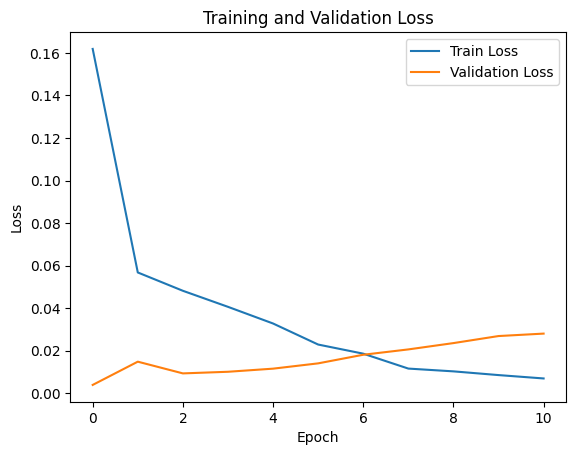

In [23]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=150, Layers=2, Dropout=0.2, Learning Rate=0.0001, Batch Size=48


In [25]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [26]:
best_model

<Sequential name=sequential_191, built=True>

#### 2) Window sampling for testing set

In [27]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Longitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Longitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 648
Test input shape: (648, 28, 1), Test target shape: (648, 1)


#### 3) Test the Testing Set Using the Imported Model

In [28]:
best_model

<Sequential name=sequential_191, built=True>

In [29]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


#### 4) Calculate Error on the Testing Set

In [30]:
y_test

array([[0.07984127],
       [0.07945496],
       [0.08081463],
       [0.09689473],
       [0.11021819],
       [0.11908444],
       [0.12016953],
       [0.12031989],
       [0.12031982],
       [0.12031992],
       [0.12031983],
       [0.12031999],
       [0.12032024],
       [0.12020191],
       [0.11912352],
       [0.11374716],
       [0.11027907],
       [0.10667152],
       [0.10104082],
       [0.10432959],
       [0.11235021],
       [0.12367134],
       [0.13580129],
       [0.14597118],
       [0.15674347],
       [0.16281843],
       [0.16674049],
       [0.17385385],
       [0.18040193],
       [0.1851654 ],
       [0.18124363],
       [0.17641968],
       [0.17561148],
       [0.17535394],
       [0.17492187],
       [0.17460507],
       [0.17459044],
       [0.17463526],
       [0.17587061],
       [0.18078684],
       [0.19153599],
       [0.19780394],
       [0.20478417],
       [0.21414615],
       [0.22381053],
       [0.23926279],
       [0.25363112],
       [0.269

In [31]:
y_pred

array([[0.12308264],
       [0.12538977],
       [0.1275352 ],
       [0.12952656],
       [0.13155556],
       [0.13376915],
       [0.1362352 ],
       [0.13889022],
       [0.14165197],
       [0.14445196],
       [0.14723153],
       [0.14994173],
       [0.15253703],
       [0.15498993],
       [0.15727593],
       [0.15936962],
       [0.161205  ],
       [0.1627461 ],
       [0.16396691],
       [0.16482835],
       [0.16541705],
       [0.16588314],
       [0.16640423],
       [0.16711175],
       [0.16814151],
       [0.16958803],
       [0.17144811],
       [0.17367817],
       [0.17626359],
       [0.17917839],
       [0.18237486],
       [0.18568875],
       [0.18889913],
       [0.19194812],
       [0.19481078],
       [0.1974898 ],
       [0.19996606],
       [0.20223144],
       [0.20428602],
       [0.2061507 ],
       [0.20789483],
       [0.20965701],
       [0.21150525],
       [0.21350518],
       [0.21575113],
       [0.21829246],
       [0.22124653],
       [0.224

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.007800219535107987


In [33]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Longitude'])

In [34]:
predictions_df.head()

,Predicted_Longitude
0,0.123083
1,0.125390
2,0.127535
3,0.129527
4,0.131556


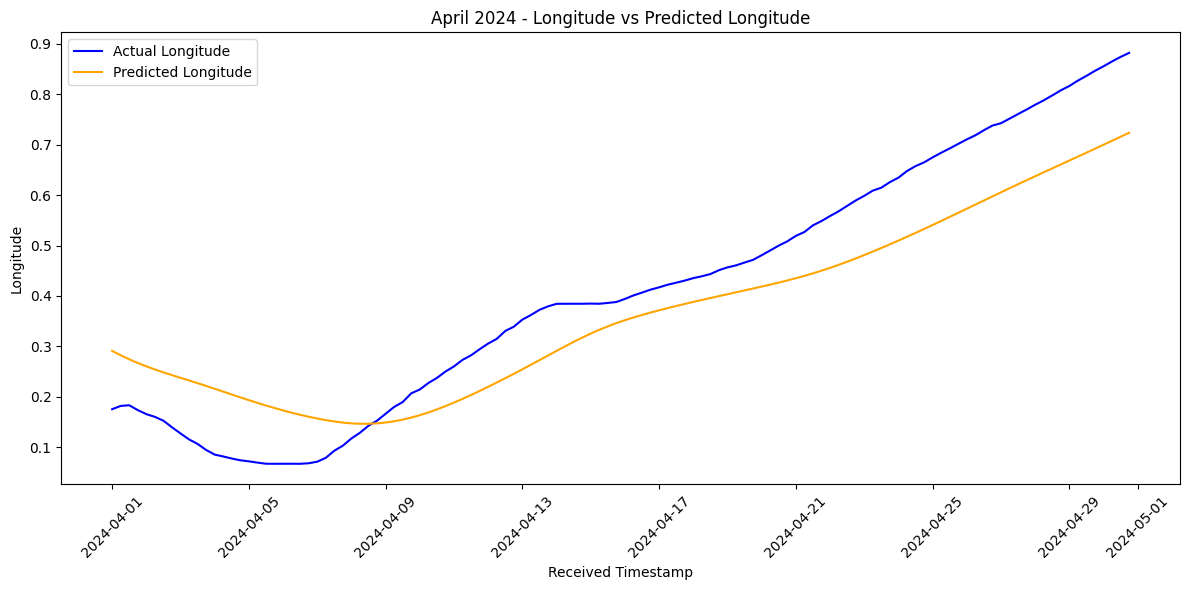

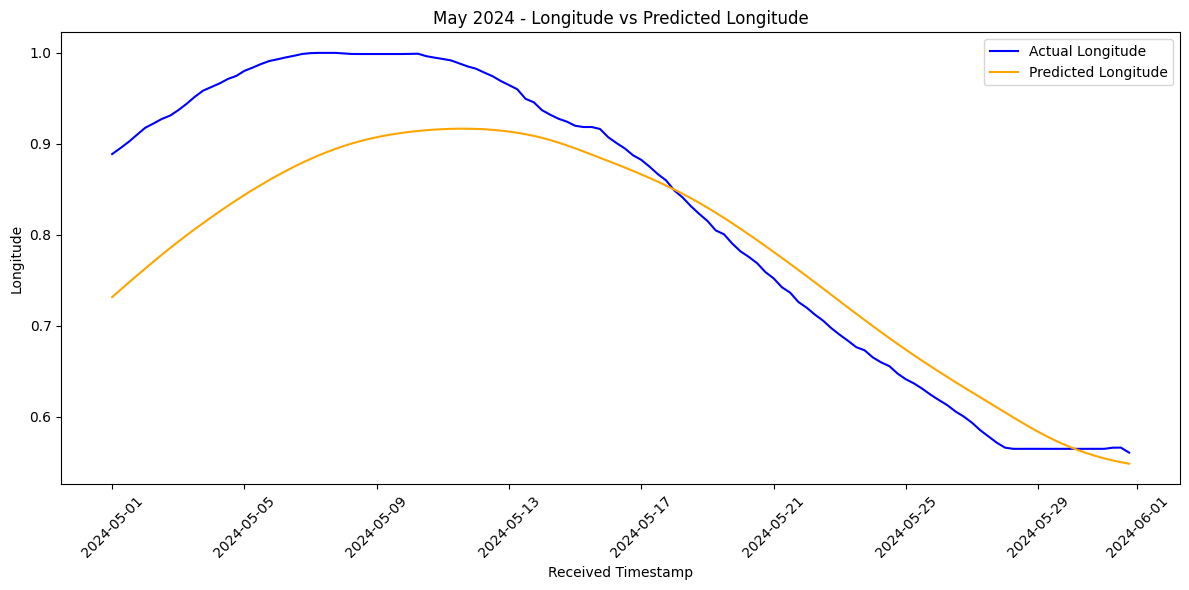

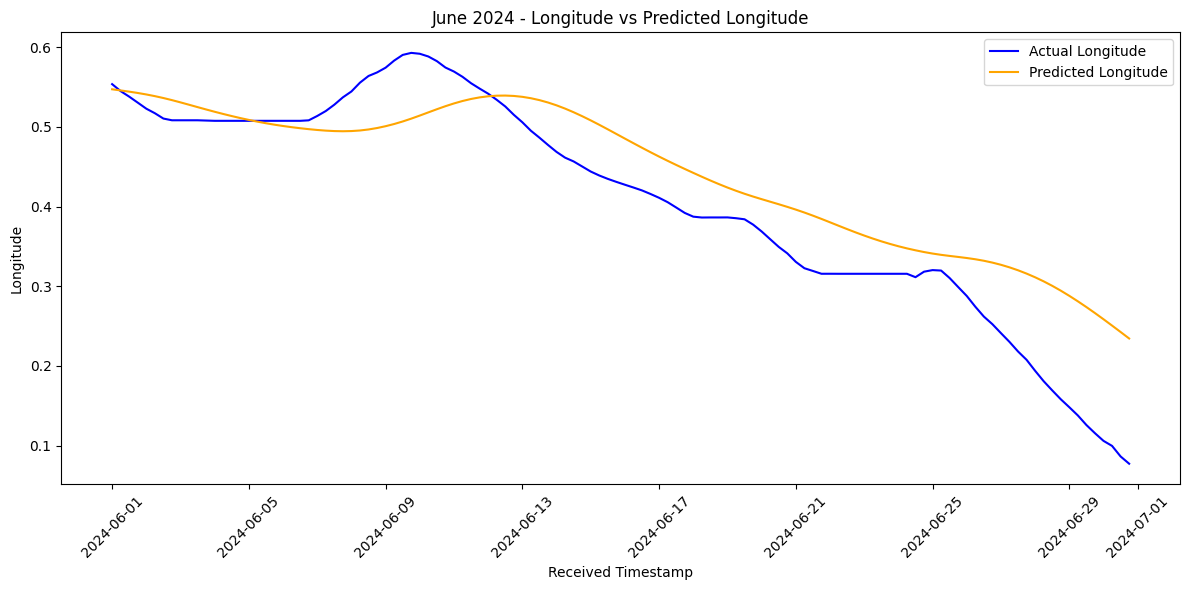

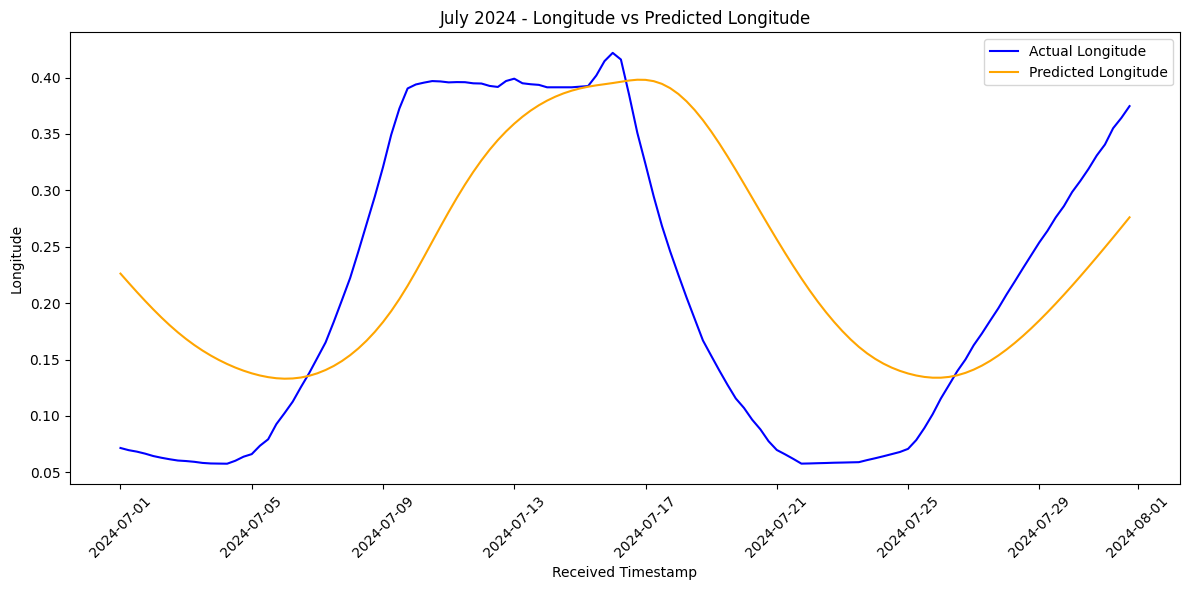

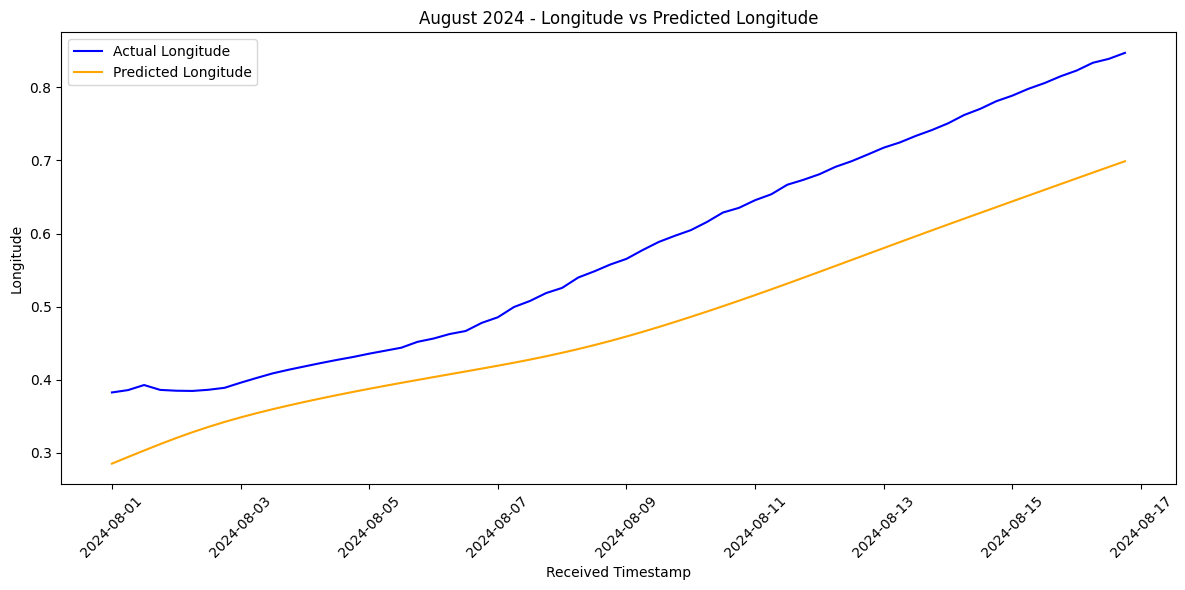

In [35]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_longitude = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Longitude'])

# Add the 'Longitude' column from `testing_set` as the true values for comparison
testing_longitudes = testing_set[['Longitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'April': '2024-04',
    'May': '2024-05',
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_longitudes[testing_longitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_longitude[predicted_longitude.index.to_period('M') == month_str]
    
    # Plot actual vs predicted longitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Longitude'], label='Actual Longitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Longitude'], label='Predicted Longitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Longitude vs Predicted Longitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Longitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [36]:
y_test_real = scaler.inverse_transform(y_test)
#y_test = y_test.reshape(-1, 1)  # Reshape if necessary
#y_pred = y_pred.reshape(-1, 1)  # Reshape if necessary

In [37]:
y_test_real

array([[-8.51939850e+00],
       [-8.57117877e+00],
       [-8.38892863e+00],
       [-6.23354273e+00],
       [-4.44765853e+00],
       [-3.25922089e+00],
       [-3.11377444e+00],
       [-3.09361962e+00],
       [-3.09362986e+00],
       [-3.09361620e+00],
       [-3.09362771e+00],
       [-3.09360643e+00],
       [-3.09357314e+00],
       [-3.10943466e+00],
       [-3.25398288e+00],
       [-3.97463310e+00],
       [-4.43949800e+00],
       [-4.92305544e+00],
       [-5.67779848e+00],
       [-5.23696976e+00],
       [-4.16188057e+00],
       [-2.64438964e+00],
       [-1.01848516e+00],
       [ 3.44692795e-01],
       [ 1.78861800e+00],
       [ 2.60290905e+00],
       [ 3.12862376e+00],
       [ 4.08210244e+00],
       [ 4.95981050e+00],
       [ 5.59830923e+00],
       [ 5.07263311e+00],
       [ 4.42602734e+00],
       [ 4.31769646e+00],
       [ 4.28317612e+00],
       [ 4.22526086e+00],
       [ 4.18279587e+00],
       [ 4.18083592e+00],
       [ 4.18684381e+00],
       [ 4.3

In [38]:
y_pred_real = scaler.inverse_transform(y_pred)
y_pred_real

array([[-2.72329998e+00],
       [-2.41405082e+00],
       [-2.12647676e+00],
       [-1.85955346e+00],
       [-1.58758497e+00],
       [-1.29087305e+00],
       [-9.60322022e-01],
       [-6.04442358e-01],
       [-2.34255567e-01],
       [ 1.41056404e-01],
       [ 5.13631999e-01],
       [ 8.76907885e-01],
       [ 1.22478414e+00],
       [ 1.55357158e+00],
       [ 1.85998869e+00],
       [ 2.14062762e+00],
       [ 2.38664246e+00],
       [ 2.59321356e+00],
       [ 2.75685120e+00],
       [ 2.87231851e+00],
       [ 2.95122838e+00],
       [ 3.01370382e+00],
       [ 3.08355141e+00],
       [ 3.17838812e+00],
       [ 3.31641769e+00],
       [ 3.51030946e+00],
       [ 3.75963593e+00],
       [ 4.05855465e+00],
       [ 4.40510511e+00],
       [ 4.79580688e+00],
       [ 5.22426462e+00],
       [ 5.66845942e+00],
       [ 6.09878063e+00],
       [ 6.50746870e+00],
       [ 6.89118147e+00],
       [ 7.25027895e+00],
       [ 7.58219814e+00],
       [ 7.88585091e+00],
       [ 8.1